In [ ]:
!pip install catboost

In [ ]:
import polars as pl
import numpy as np
import urllib.request
import io
import collections
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import catboost

In [ ]:
sns.set_theme()

In [ ]:
def get_file_from_github(name):
  assert name is not None
  req = urllib.request.Request(
      url=f"https://api.github.com/repos/niuk-a/examples/contents/datasets/kaggle-food-delivery/{name}",
      method='GET',
      headers={
          "Accept" : "application/vnd.github.raw+json",
          "Authorization" : "Bearer <TOKEN>",
          "X-GitHub-Api-Version" : "2022-11-28",
      }
  )
  with urllib.request.urlopen(req) as f:
    return f.read()

In [ ]:
def rm_nan(col):
  return col.str.strip_chars().replace({"NaN" : None})

def preproc(content):
  schema = collections.OrderedDict([
    ('ID', pl.Utf8),
    ('Delivery_person_ID', pl.Utf8),
    ('Delivery_person_Age', pl.Int32),
    ('Delivery_person_Ratings', pl.Float32),
    ('Restaurant_latitude', pl.Float32),
    ('Restaurant_longitude', pl.Float32),
    ('Delivery_location_latitude', pl.Float32),
    ('Delivery_location_longitude', pl.Float32),
    ('Order_Date', pl.Date),
    ('Time_Orderd', pl.Time),
    ('Time_Order_picked', pl.Time),
    ('Weatherconditions', pl.Utf8),
    ('Road_traffic_density', pl.Utf8),
    ('Vehicle_condition', pl.Int8),
    ('Type_of_order', pl.Utf8),
    ('Type_of_vehicle', pl.Utf8),
    ('multiple_deliveries', pl.Int8),
    ('Festival', pl.Boolean),
    ('City', pl.Utf8),
    ('Time_taken(min)', pl.Int32)
  ])
  return (
      pl.read_csv(io.BytesIO(content))
      .with_columns(
          pl.col("ID").str.strip_chars(),
          pl.col("Delivery_person_ID").str.strip_chars(),
          rm_nan(pl.col("Delivery_person_Age")),
          rm_nan(pl.col("Delivery_person_Ratings")),
          pl.col("Order_Date").str.strptime(dtype=pl.Date, format="%d-%m-%Y"),
          rm_nan(pl.col("Time_Orderd")).str.strptime(dtype=pl.Time, format="%H:%M:%S"),
          rm_nan(pl.col("Time_Order_picked")).str.strptime(dtype=pl.Time, format="%H:%M:%S"),
          pl.col("Weatherconditions").str.slice(len("conditions") + 1).replace({"NaN" : None}),
          rm_nan(pl.col("Road_traffic_density")),
          pl.col("Type_of_order").str.strip_chars(),
          pl.col("Type_of_vehicle").str.strip_chars(),
          rm_nan(pl.col("multiple_deliveries")),
          rm_nan(pl.col("Festival")),
          rm_nan(pl.col("City")),
          pl.col("Time_taken(min)").str.slice(6)
      )
      .with_columns(
          Festival=(
              pl.when(pl.col("Festival") == "Yes").then(True)
              .when(pl.col("Festival") == "No").then(False)
              .otherwise(None)
          )
      ).cast(schema)
  )

In [ ]:
def create_features(df, cat_columns):
  return (
    df
    .with_columns(
        dist=(
            (pl.col("Restaurant_latitude") - pl.col("Delivery_location_latitude")) ** 2
            +
            (pl.col("Restaurant_longitude") - pl.col("Delivery_location_longitude")) ** 2
        ).sqrt() / 180 * np.pi * 6372,
        wd=pl.col("Order_Date").dt.weekday(),
        hour=pl.col("Time_Order_picked").dt.hour(),
        pickup=(
            pl.lit(datetime.date(2000,1,1)).dt.combine(pl.col("Time_Order_picked"))
            -
            pl.lit(datetime.date(2000,1,1)).dt.combine(pl.col("Time_Orderd"))
        ).dt.total_seconds() / 60,
        Ratings_5=pl.sum_horizontal(
            pl.col("Delivery_person_Ratings") < x
            for x in [3.5, 4, 4.5, np.inf]
        ),
    )
    .with_columns(
        part_of_day=pl.sum_horizontal(
            pl.col("hour") < x for x in [1, 8, 13, 17, 25]
        ).replace(
            dict(enumerate(["evening", "night", "morning", "daytime", "evening",]))
        )
    )
    .with_columns(*(pl.col(col).cast(pl.Utf8) for col in cat_columns))
    .with_columns(*(pl.col(col).fill_null("UNK") for col in cat_columns))
    .with_columns(target = pl.col("dist") / pl.col("Time_taken(min)"))
  )

In [ ]:
cat_columns = [
    "Delivery_person_ID", "wd", "part_of_day", "Weatherconditions",
    "Road_traffic_density", "Vehicle_condition", "Type_of_order",
    "Type_of_vehicle", "multiple_deliveries",
    "Festival", "City", "Ratings_5"
]
df = preproc(get_file_from_github("train.csv"))
X_train = create_features(df.filter(pl.col("Order_Date") < datetime.date(2022,4,1)), cat_columns)
X_test = create_features(df.filter(pl.col("Order_Date") >= datetime.date(2022,4,1)), cat_columns)

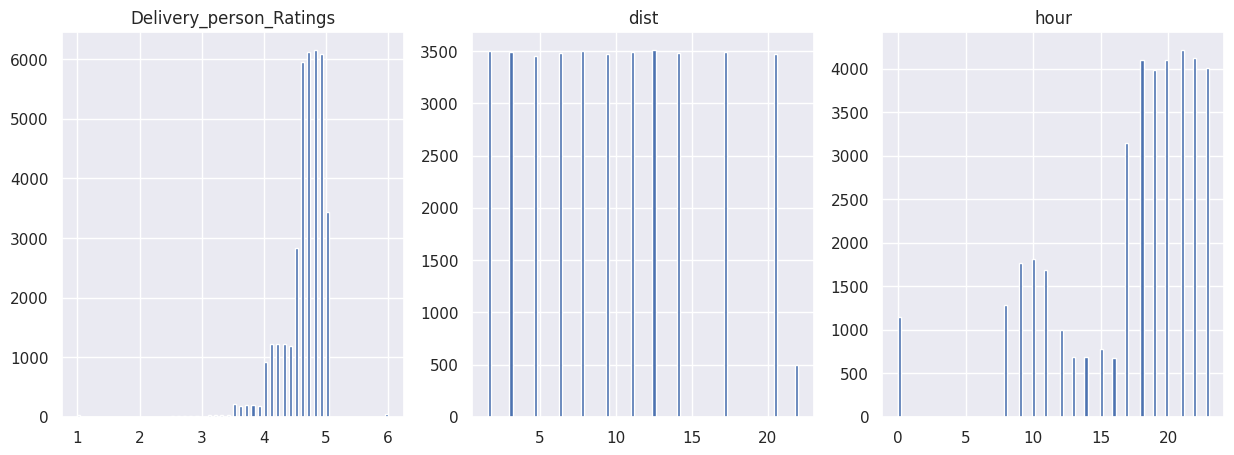

In [ ]:
plt.figure(figsize=[15,5])
plt.subplot(131)
plt.title("Delivery_person_Ratings")
_ = plt.hist(X_train["Delivery_person_Ratings"], bins=100)

plt.subplot(132)
plt.title("dist")
_ = plt.hist(X_train.filter(pl.col("dist") < 200)["dist"], bins=100)

plt.subplot(133)
plt.title("hour")
_ = plt.hist(X_train["hour"].cast(pl.Int32), bins=100)

In [ ]:
X_columns = [
    'Delivery_person_ID',
    'Delivery_person_Age',
    'Ratings_5',
    'dist',
    "wd",
    "part_of_day",
    "pickup",
    'Weatherconditions',
    'Road_traffic_density',
    'Vehicle_condition',
    'Type_of_order',
    'Type_of_vehicle',
    'multiple_deliveries',
    'Festival',
    'City'
]

train_pool = catboost.Pool(
    data=X_train[X_columns].to_pandas(),
    label=X_train["target"].cast(pl.Float32).to_numpy(),
    cat_features=[i for i,c in enumerate(X_columns) if c in cat_columns]
)
test_pool = catboost.Pool(
    data=X_test[X_columns].to_pandas(),
    label=X_test["target"].cast(pl.Float32).to_numpy(),
    cat_features=[i for i,c in enumerate(X_columns) if c in cat_columns]
)

In [ ]:
reg = catboost.CatBoostRegressor(iterations=200, learning_rate=0.05, early_stopping_rounds=5)
reg.fit(train_pool, eval_set=test_pool)

0:	learn: 52.1886463	test: 46.0251755	best: 46.0251755 (0)	total: 166ms	remaining: 32.9s
1:	learn: 50.0536797	test: 44.0919930	best: 44.0919930 (1)	total: 248ms	remaining: 24.6s
2:	learn: 48.1864951	test: 42.5037387	best: 42.5037387 (2)	total: 353ms	remaining: 23.2s
3:	learn: 46.2468629	test: 40.7629238	best: 40.7629238 (3)	total: 410ms	remaining: 20.1s
4:	learn: 44.4481149	test: 39.1128607	best: 39.1128607 (4)	total: 474ms	remaining: 18.5s
5:	learn: 42.7863829	test: 37.6273478	best: 37.6273478 (5)	total: 593ms	remaining: 19.2s
6:	learn: 41.1538428	test: 36.1390419	best: 36.1390419 (6)	total: 649ms	remaining: 17.9s
7:	learn: 39.6386116	test: 34.7556898	best: 34.7556898 (7)	total: 730ms	remaining: 17.5s
8:	learn: 38.2029410	test: 33.4583634	best: 33.4583634 (8)	total: 815ms	remaining: 17.3s
9:	learn: 36.9615860	test: 32.5047946	best: 32.5047946 (9)	total: 909ms	remaining: 17.3s
10:	learn: 35.6795836	test: 31.4445826	best: 31.4445826 (10)	total: 1s	remaining: 17.2s
11:	learn: 34.4522944	

In [ ]:
for c, n in sorted(zip(reg.feature_importances_, reg.feature_names_)):
  print("+" if n in cat_columns else " ", X_train[n].n_unique() if n in cat_columns else " ", n, c)

+ 1320 Delivery_person_ID 0.10654122218156994
+ 4 Type_of_order 0.11444866333505452
+ 5 Ratings_5 0.5338660788049349
+ 7 wd 0.6177870655543783
+ 4 Type_of_vehicle 0.618170447167668
    Delivery_person_Age 0.663464845561796
    pickup 0.6818052395238071
+ 4 part_of_day 0.8005678445070362
+ 7 Weatherconditions 1.624398136094282
+ 5 multiple_deliveries 1.7535758480823551
+ 4 Vehicle_condition 1.8627295806810569
+ 3 Festival 2.3819858001887813
+ 4 City 2.81293674372585
+ 5 Road_traffic_density 3.32062788147623
    dist 82.10709460311527


<ipython-input-13-02c5502ae13d>:7: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


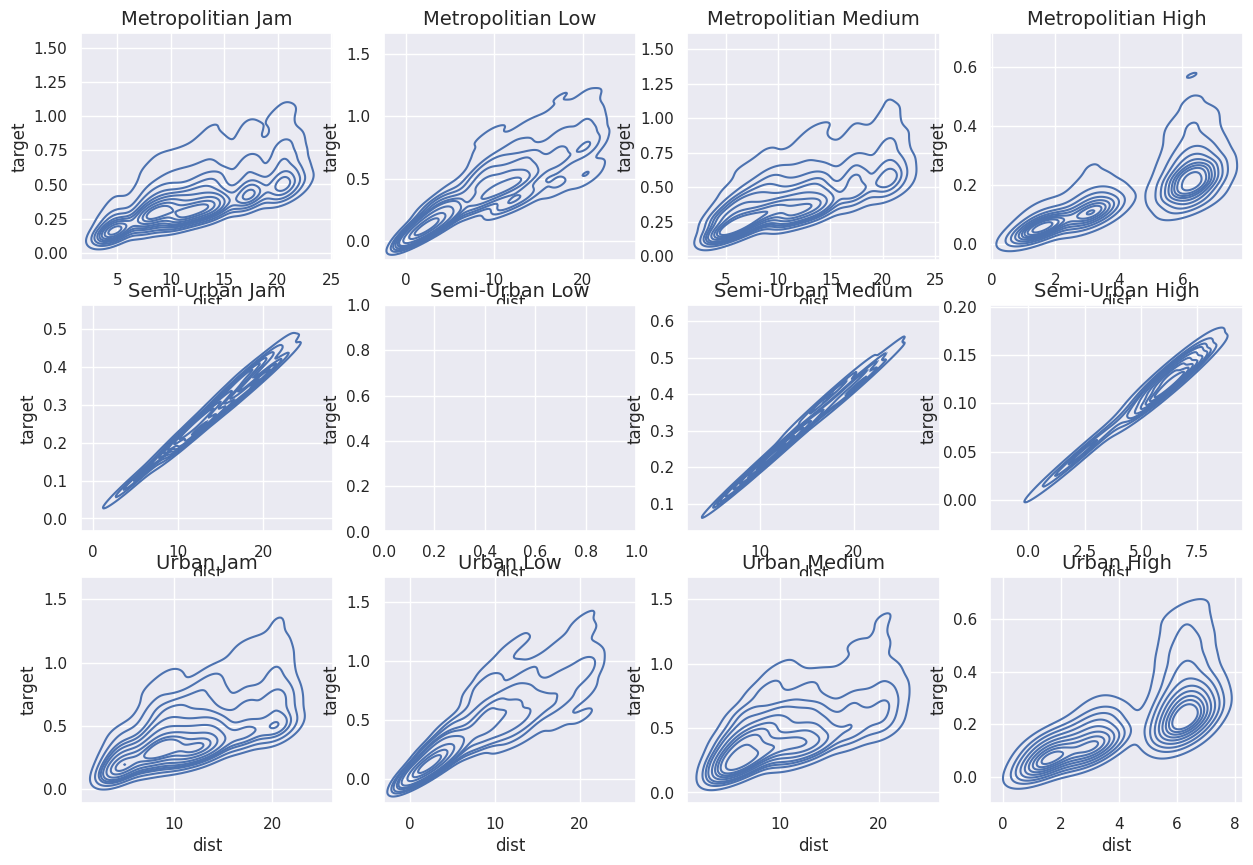

In [ ]:
cities = [city for city in X_train["City"].unique() if city != "UNK"]
traffics = [traffic for traffic in X_train["Road_traffic_density"].unique() if traffic != "UNK"]
fig, axs = plt.subplots(nrows=len(cities), ncols=len(traffics), figsize=[15,10])
for ax_row, city in zip(axs,cities):
  for ax, traffic in zip(ax_row, traffics):
    ax.set_title(f"{city} {traffic}", fontsize=14)
    sns.kdeplot(
        data=X_train.filter(
            (pl.col("dist") < 25)
            & (0 < pl.col("target"))
            & (pl.col("target") < 1.5)
            & (pl.col("Road_traffic_density") == traffic)
            & (pl.col("City") == city)
        ).to_pandas(),
        x="dist", y="target",
        ax=ax
    )